In [2]:
import numpy as np
from util.willshaw.memory import *
from util.willshaw.eval import *
from util.mnist.tools import read_mnist
from util.pickleInterface import *
from util.whatwhere.plot import *
from util.whatwhere.noise import *
from util.whatwhere.description_encoding import *
from util.whatwhere.generate import *
from util.whatwhere.decoder import *
from util.plot import *

In [34]:
rng = np.random.RandomState(0)  # reproducible
""" Fixed params """
K = 20  # number of k-means centroids
n_epochs = 5  # for the k means feature detection
b = 0.8  # minimum activity of the filters: prevents empty feature detection
Q = 21  # size of the final object space grid
wta = True  # winner takes all

Fs = 2  # size of features, Fs = 1 results in a 3by3 filter size (2Fs+1)
T_what = 0.9  # Treshod for keeping or discarding a detected feature

In [35]:
trn_imgs, trn_lbls, tst_imgs, tst_lbls = read_mnist()
features = compute_features(trn_imgs, trn_lbls, K, Fs, rng, n_epochs, b)
codes, _ = compute_codes(
    trn_imgs,
    K,
    Q,
    features,
    T_what,
    wta,
    n_epochs,
    b,
    Fs,
    set="trn",
)

tst_codes, _ = compute_codes(
    tst_imgs,
    K,
    Q,
    features,
    T_what,
    wta,
    n_epochs,
    b,
    Fs,
    set="tst",
)

In [36]:
print(codes.shape)
print(tst_codes.shape)

(60000, 8820)
(10000, 8820)


Task 0: Auto-Association
    - join lbl encoding with code (lbl|code)
    - store the concatenated code in a WN.
    - retrieve the coded set
    - compare the lbl from coded set and ret set 

In [37]:
def autoassociation(desCodes, desc_size, full_memory):
    """
    Measures how good the memory is at maintaining the correct label in
    auto-association.
    @param desCodes: 2D binary csr_matrix (desc|code)
    @param desc_size: size of description
    @param full_memory: AAWN memory already storing desCodes 
    """
    ret = full_memory.retrieve(desCodes)
    descs_ret = separate(ret, desc_size)[0]
    descs = separate(desCodes, desc_size)[0]
    #correct = np.sum((descs == descs_ret).all(1))
    #print(f"ret_desc == desc in {correct}/{ret.shape[0]} times.")
    return (descs, descs_ret)

Task 1: Completion
    - join lbl encoding with code (lbl|code)
    - store the concatenated code in a WN.
    - retrieve codes without labels (empty|code)
    - compare the lbl from coded set and ret set 

In [44]:
def completion(desCodes, desc_size, full_memory):
    """
    Measures how good the memory is at completing the missing
    desc of stored patterns
    @param desCodes: 2D binary csr_matrix (desc|code)
    @param desc_size: size of description
    @param full_memory: AAWN memory already storing desCodes 
    """
    descs, codes = separate(desCodes, desc_size)
    empty_descs = np.zeros_like(descs)
    just_codes = join(empty_descs, codes)
    ret = full_memory.retrieve(just_codes)
    descs_ret = separate(ret, desc_size)[0]
    #correct = np.sum((descs == descs_ret).all(1))
    #print(f"ret_desc == desc in {correct}/{ret.shape[0]} times.")
    return (descs, descs_ret)

Task 2: Classification
    - join lbl encoding with code (lbl|code)
    - store the concatenated code in a WN.
    - encode the test set, and add an empty lbl (empty|tst_codes)
    - compute ret set and compare obtained lbls with the correct ones.

In [39]:
def classification(tst_desCodes, desc_size, full_memory):
    """
    Measures how good the memory is predicting the label of a unseen pattern
    @param desCodes: 2D binary csr_matrix (desc|code) with test set
    @param desc_size: size of description
    @param full_memory: AAWN memory already storing desCodes 
    """
    tst_descs, tst_codes = separate(tst_desCodes, desc_size)
    empty_descs = np.zeros_like(tst_descs)
    just_codes = join(empty_descs, tst_codes)
    ret = full_memory.retrieve(just_codes)
    descs_ret = separate(ret, desc_size)[0]
    #correct = np.sum((tst_descs == descs_ret).all(1))
    #print(f"ret_desc == desc in {correct}/{ret.shape[0]} times.")
    return (tst_descs, descs_ret)


Task 3: Generation
    - join lbl encoding with code (lbl|code)
    - store the concatenated code in a WN.
    - create a set of descriptions without code (desc|empty)
    - retrieve the description
    - Inspect the generations from each class
    3.1:
        - Add some random noise to the code to act as a seed (sample from distribution of codes until sparsity is similar)
        - Add some class-dependent noise.

In [45]:
def generate(gen_desCodes, full_memory, desc_size):
    ret = full_memory.retrieve(gen_desCodes)
    gen_codes = separate(ret, desc_size)[1]
    return gen_codes

In [49]:
descs = x_hot_encoding(trn_lbls, x=3)
tst_descs = x_hot_encoding(tst_lbls, x=3)
gen_lbls = np.repeat(np.arange(10), 10) # 10 examples from each class
gen_descs = x_hot_encoding(tst_lbls, x=3)
desc_size = descs.shape[1] 

In [50]:
code_size = codes.shape[1]
desCodes = join(descs, codes)
tst_desCodes = join(tst_descs, tst_codes)

In [51]:
"""Store the (desc|codes) in a AAWN"""
wn = AAWN(desCodes.shape[1])
wn.store(desCodes)

In [52]:
#autoassociation(desCodes, desc_size, wn)
desc, ret_desc = completion(desCodes, desc_size, wn)
#classification(tst_desCodes, desc_size, wn)

ret_desc == desc in 8702/60000 times.


In [53]:
measure_sparsity(csr_matrix(desc), verbose=True)
measure_sparsity(csr_matrix(ret_desc), verbose=True)


avg sparsity = 0.1
densest (%B) = 0.1
avg sparsity = 0.3512533333333333
densest (%B) = 1.0


(0.3512533333333333, 1.0)

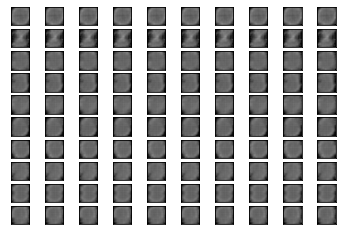

In [17]:
#gen_lbls = np.repeat(np.arange(10), 10) # 10 examples from each class
n = 10
gen_imgs = np.empty(shape=(10*n,28,28))
for i in range(10):
    gen_lbls = np.repeat([i], n)
    gen_descs = x_hot_encoding(gen_lbls)

    seed = csr_matrix(np.zeros(shape=(n,K*Q*Q)))

    gen_desCodes = join(gen_descs, seed)

    gen_codes = generate(gen_desCodes, wn, desc_size)
    gen_imgs[i*n:(i+1)*n] = recon_no_polar(gen_codes, features, Q, K)
    

multiple_imshow(gen_imgs, layout=(10,n))

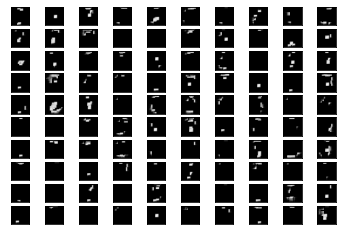

In [18]:
#gen_lbls = np.repeat(np.arange(10), 10) # 10 examples from each class
n = 10
gen_imgs = np.empty(shape=(10*n,28,28))
for i in range(10):
    gen_lbls = np.repeat([i], n)
    gen_descs = x_hot_encoding(gen_lbls)

    dist = compute_prob_dist(codes)
    seed = sample_from_dist(dist, n)

    gen_desCodes = join(gen_descs, seed)

    gen_codes = generate(gen_desCodes, wn, desc_size)
    gen_imgs[i*n:(i+1)*n] = recon_no_polar(gen_codes, features, Q, K)
    

multiple_imshow(gen_imgs, layout=(10,n))

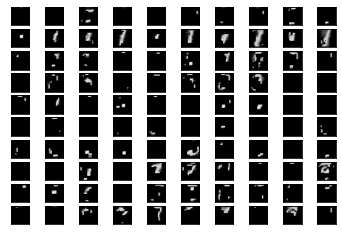

In [20]:
#gen_lbls = np.repeat(np.arange(10), 10) # 10 examples from each class
n = 10
gen_imgs = np.empty(shape=(10*n,28,28))
for i in range(10):
    gen_lbls = np.repeat([i], n)
    gen_descs = x_hot_encoding(gen_lbls)

    dist = compute_prob_dist(codes[trn_lbls==i])
    seed = sample_from_dist(dist, n)

    gen_desCodes = join(gen_descs, seed)

    gen_codes = generate(gen_desCodes, wn, desc_size)
    gen_imgs[i*n:(i+1)*n] = recon_no_polar(gen_codes, features, Q, K)
    

multiple_imshow(gen_imgs, layout=(10,n))